<a href="https://colab.research.google.com/github/matheusfdario/fourier-mellin-image-registration/blob/main/MFD_PC_MELIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier–Mellin domain 2-D Phase Correlation Algorithm

References:



* An FFT-based technique for translation, rotation and scale-invariant image registration. BS Reddy, BN Chatterji. IEEE Transactions on Image Processing, 5, 1266-1271, 1996
* An IDL/ENVI implementation of the FFT-based algorithm for automatic image registration. H Xiea, N Hicksa, GR Kellera, H Huangb, V Kreinovich. Computers & Geosciences, 29, 1045-1055, 2003.
* Image Registration Using Adaptive Polar Transform. R Matungka, YF Zheng, RL Ewing. IEEE Transactions on Image Processing, 18(10), 2009.
* TONG, Xiaohua et al. Image registration with Fourier-based image correlation: A comprehensive review of developments and applications. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, v. 12, n. 10, p. 4062-4081, 2019.






First, generate two images displaced, rotated and scaled from one another.


(1024, 1024)
0.6287423035070528
(512, 512) (512, 512)


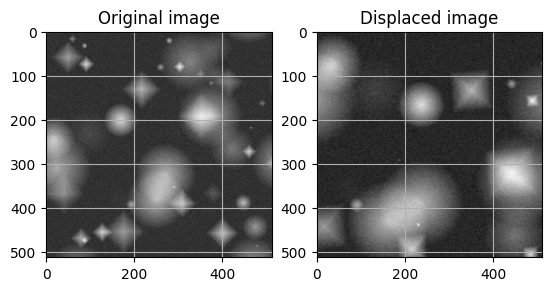

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.cbook as cbook
from numpy.random import RandomState
from scipy import ndimage
######## PARAMETERS #########
displacement_x = -15
displacement_y = -35
rotation_deg = 40 # rotação em graus
scale_ratio = 1.4

plot = True
#############################

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, warp
from numpy.random import RandomState

def img_gen(x=2048,y=2048,ncirc=100,nsqr=100, normalize=True, add_noise=True, seed=1234):
    img = np.zeros((x, y), dtype=float)
    prng = RandomState(seed)

    Y, X = np.meshgrid(range(y), range(x))  # cuidado com ordem (Y, X)

    # ---- Círculos ----
    circ = prng.rand(ncirc, 4)   # [cx_rel, cy_rel, raio_rel, intensidade]
    for i in range(circ.shape[0]):
        cx = circ[i,0]*x
        cy = circ[i,1]*y
        r  = circ[i,2]*80
        peak = circ[i,3]

        dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
        mask = dist <= r
        intensity = (1 - dist/r) * mask
        img += peak * np.clip(intensity, 0, 1)

    # ---- Quadrados ----
    sqr = prng.rand(nsqr, 4)  # [cx_rel, cy_rel, raio_rel, intensidade]
    for i in range(sqr.shape[0]):
        cx = sqr[i,0]*x
        cy = sqr[i,1]*y
        r  = sqr[i,2]*60
        peak = sqr[i,3]

        dist = np.abs(X - cx) + np.abs(Y - cy)  # Manhattan (L1)
        mask = dist <= r
        intensity = (1 - dist/r) * mask
        img += peak * np.clip(intensity, 0, 1)

    # ---- Ruído ----
    if add_noise:
        noise = prng.normal(0, 0.05, img.shape)  # média 0, desvio 0.05
        img += noise

    # ---- Normalização ----
    if normalize and img.max() > 0:
        img = (img - img.min()) / (img.max() - img.min())
    print(noise.shape)
    return img



def transform_image(img, scale=1.0, angle_deg=0.0, shift=(0,0)):
    """
    Aplica escala, rotação e translação a uma imagem usando map_coordinates.
    Mantém o shape original e permite subpixel.
    """
    x, y = img.shape
    cx, cy = x/2, y/2
    X, Y = np.meshgrid(np.arange(x), np.arange(y), indexing='ij')

    # centraliza
    Xc = X - cx
    Yc = Y - cy

    # rotação
    theta = np.deg2rad(angle_deg)
    Xr = np.cos(theta)*Xc - np.sin(theta)*Yc
    Yr = np.sin(theta)*Xc + np.cos(theta)*Yc

    # escala
    Xr /= scale
    Yr /= scale

    # translação
    Xr += shift[0]
    Yr += shift[1]

    # volta para coordenadas da imagem
    Xr += cx
    Yr += cy

    # remapeia
    img_transformed = ndimage.map_coordinates(img, [Xr, Yr], order=1, mode='reflect')
    return img_transformed


# 1. gera a base
img_size = 1024 # must be a square

base_img = img_gen(x=img_size,y=img_size,add_noise=True)

# 2. aplica transformações
f = transform_image(base_img, scale=1.0, angle_deg=0, shift=(0,0))
g = transform_image(base_img, scale=scale_ratio, angle_deg=rotation_deg, shift=(displacement_x,displacement_y))

f = f[int(img_size/4):int(-img_size/4),int(img_size/4):int(-img_size/4)]
g = g[int(img_size/4):int(-img_size/4),int(img_size/4):int(-img_size/4)]

if plot is True:
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(np.log(f+1), cmap='gray')
  title = plt.title('Original image')
  plt.grid()
  plt.subplot(1,2,2)
  plt.imshow(np.log(g+1), cmap='gray')
  title = plt.title('Displaced image')
  plt.grid()
  print(f.max())
  print(f.shape,g.shape)

Then apply fft and a highpass filter in both images. The highpass filter is used to reduce erros in the next step of this pipelane.

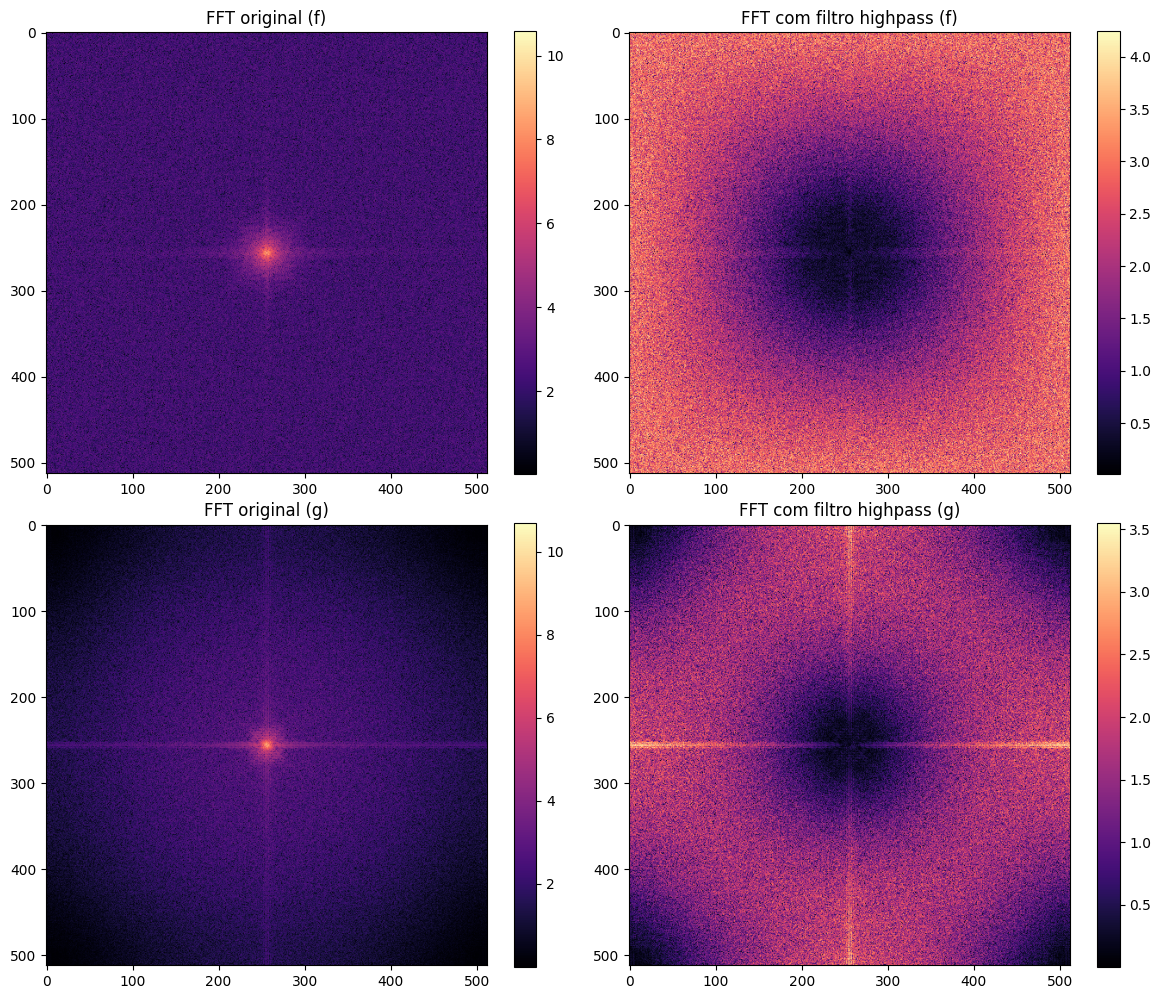

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

def highpass(shape: tuple[int, ...]):
    """Return highpass filter to be multiplied with Fourier transform."""
    x = np.outer(
        np.cos(np.linspace(-math.pi / 2.0, math.pi / 2.0, shape[0])),
        np.cos(np.linspace(-math.pi / 2.0, math.pi / 2.0, shape[1])),
    )
    return (1.0 - x) * (2.0 - x)

# FFT das imagens
F0 = fftshift(abs(fft2(f)))
G0 = fftshift(abs(fft2(g)))

# aplica filtro
hF = highpass(F0.shape)
hG = highpass(G0.shape)
F = F0 * hF
G = G0 * hG

# --- plots ---
plt.figure(figsize=(12, 10))

# f original
plt.subplot(2, 2, 1)
plt.imshow(np.log1p(F0), cmap="magma")
plt.title("FFT original (f)")
plt.colorbar()

# f filtrado
plt.subplot(2, 2, 2)
plt.imshow(np.log1p(F), cmap="magma")
plt.title("FFT com filtro highpass (f)")
plt.colorbar()

# g original
plt.subplot(2, 2, 3)
plt.imshow(np.log1p(G0), cmap="magma")
plt.title("FFT original (g)")
plt.colorbar()

# g filtrado
plt.subplot(2, 2, 4)
plt.imshow(np.log1p(G), cmap="magma")
plt.title("FFT com filtro highpass (g)")
plt.colorbar()

plt.tight_layout()
plt.show()


Next, convert the fft of both images from a cartesian cordinates to log-polar coordinates. A funtion aveilable in the library [imreg](https://pypi.org/project/imreg/) was used for this convesion because only the upper two quadrants of the Fourier log-magnitude spectra of images are used to map them to polar plane in the method proposed for Reddy and Chatterji(1996). An standard cartesian to log-polar conversion colud not be used because all of then uses the Fourier log-magnitude spectra of images.

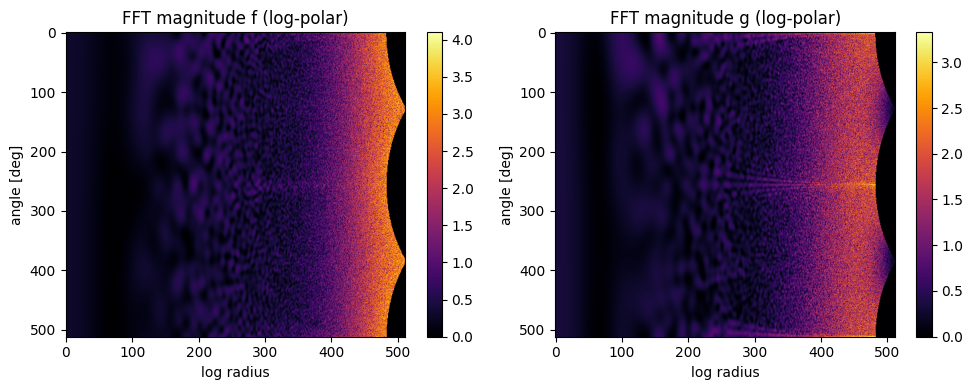

In [3]:
from scipy import ndimage
def logpolar(image):
    """Return log-polar transformed image and log base."""
    image = np.asanyarray(image)
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    angles = shape[0]
    radii = shape[1]
    theta = np.empty((angles, radii), dtype='float64')
    theta.T[:] = np.linspace(0, np.pi, angles, endpoint=False) * -1.0
    # d = radii
    d = np.hypot(shape[0] - center[0], shape[1] - center[1])
    log_base = 10.0 ** (math.log10(d) / (radii))
    radius = np.empty_like(theta)
    radius[:] = (
        np.power(log_base, np.arange(radii, dtype='float64')) - 1.0
    )
    x = radius * np.sin(theta) + center[0]
    y = radius * np.cos(theta) + center[1]
    output = np.empty_like(x)
    ndimage.map_coordinates(image, [x, y], output=output)
    return output, log_base, d, radii


FLB, log_base, d, radii = logpolar(F)
GLB, log_base, d, radii = logpolar(G)



if plot is True:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(np.log1p(np.abs(FLB)), cmap="inferno", aspect='auto')
    plt.title("FFT magnitude f (log-polar)")
    plt.xlabel("log radius"), plt.ylabel("angle [deg]")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(np.log1p(np.abs(GLB)), cmap="inferno", aspect='auto')
    plt.title("FFT magnitude g (log-polar)")
    plt.xlabel("log radius"), plt.ylabel("angle [deg]")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


After that, apply fft again and make cross power spectrum of both images. Apply ifft to get the phased correlation of the images.

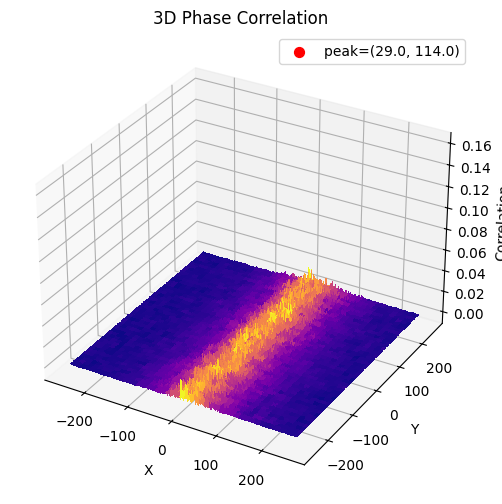

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2

# FFTs
f0 = fft2(FLB)
f1 = fft2(GLB)

# Cross power spectrum
r0 = np.abs(f0) * np.abs(f1)
r0[r0 == 0] = 1e-8  # evita divisão por zero
cross_power = (f0 * np.conjugate(f1)) / r0

# Phase correlation
ir = np.abs(ifft2(cross_power))
ir_shift = fftshift(ir)   # <<< isso centraliza o pico
# --- Plot 3D ---
from mpl_toolkits.mplot3d import Axes3D


# Eixos alinhados ao shift
ny, nx = ir.shape
X = np.fft.fftfreq(nx) * nx   # gera -nx/2..nx/2-1
Y = np.fft.fftfreq(ny) * ny
X = fftshift(X)
Y = fftshift(Y)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, ir_shift, cmap="plasma", linewidth=0, antialiased=False)

# destacar o pico
i0, i1 = np.unravel_index(np.argmax(ir_shift), ir_shift.shape)
ax.scatter(X[i0, i1], Y[i0, i1], ir[i0, i1],color="red", s=50, label=f"peak=({X[i0,i1]}, {Y[i0,i1]})")
ax.legend()

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Correlation")
ax.set_title("3D Phase Correlation")

plt.show()

Get angle and scale from peak.

In [5]:
# --- Pico de correlação ---
i0, i1 = np.unravel_index(np.argmax(ir), ir.shape)
#if i0 > ir.shape[0] // 2:
#   i0 -= ir.shape[0]

angle = 180.0 * i0 / ir.shape[0]
scale = d ** (i1 / radii)

print(f"Final estimate -> scale: {scale:.3f}, angle: {angle:.2f}°")

Final estimate -> scale: 1.396, angle: 40.08°


 In determining the angle there is a 180 degrees ambiguity. This
can be resolved in the following manner. First, the translation is determined by rotating the spectrum of one of the images by the calculeted angle. We then rotate the spectrum of the imagem by an angle 180 higher than the previous one and again compute the translation. If the value of the peak of the IFFT of the cross-power spectrum phase is greater when the fisth angle, then the true angle of rotation is the fisth one, otherwise the true angle of rotation is 180 higher than the fisth angle.

Scale: 1.3961416406168097
Angle: 40.078125


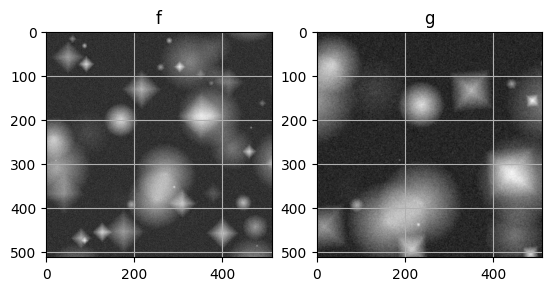

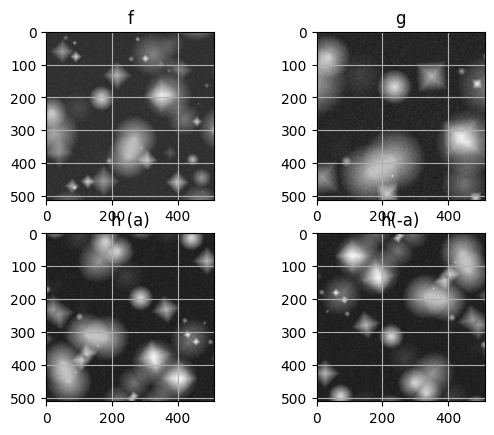

In [6]:

from scipy import ndimage
print("Scale:", scale)
print("Angle:", angle)
h0 = transform_image(g, scale=1.0/scale, angle_deg=angle, shift=(0,0))
h1 = transform_image(g, scale=1.0/scale, angle_deg=(180+angle),shift=(0,0))
if plot is True:
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(np.log(f+1), cmap='gray')
  title = plt.title('f')
  plt.grid()
  plt.subplot(1,2,2)
  plt.imshow(np.log(g+1), cmap='gray')
  title = plt.title('g')
  plt.grid()
  plt.figure()
  plt.subplot(2,2,1)
  plt.imshow(np.log(f+1), cmap='gray')
  title = plt.title('f')
  plt.grid()
  plt.subplot(2,2,2)
  plt.imshow(np.log(g+1), cmap='gray')
  title = plt.title('g')
  plt.grid()
  plt.subplot(2,2,3)
  plt.imshow(np.log(h0+1), cmap='gray')
  title = plt.title('h (a)')
  plt.grid()
  plt.subplot(2,2,4)
  plt.imshow(np.log(h1+1), cmap='gray')
  title = plt.title('h(-a)')
  plt.grid()

Use ifft of the cross power spectrum of the two angles to detecte which angle presents the highest peak. The angle with the highest peak corresponds to the correct estimation.

In [8]:
f0 = fft2(f)
h0 = transform_image(g, scale=1.0/scale, angle_deg=-angle, shift=(0,0))
h1 = transform_image(g, scale=1.0/scale, angle_deg=-(180+angle), shift=(0,0))
f1 = fft2(h0)
ir0 = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))

f1 = fft2(h1)  # type: ignore
ir1 = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
print(angle)
print(ir0.max(),ir1.max())
if(ir0.max()>ir1.max()):
  ir = ir0
  f_angle = angle
else:
  ir = ir1
  f_angle = 180+angle

dx, dy = np.unravel_index(np.argmax(ir), ir.shape)
if dx > f0.shape[0] // 2:
    dx -= f0.shape[0]
if dy > f0.shape[1] // 2:
    dy -= f0.shape[1]
print("scale = ",scale)
print("angle = ", f_angle)
print("dx = ",dx)
print("dy = ",dy)

40.078125
0.2976807197489585 0.010197709179463249
scale =  1.3961416406168097
angle =  40.078125
dx =  -15
dy =  -35
